        pca1      pca2
0  -0.055517  0.130053
1  -0.091811  0.007432
2   0.026960  0.294871
3  -0.022516 -0.069599
4  -0.029271 -0.117436
..       ...       ...
95  0.075935 -0.005321
96 -0.108484  0.190176
97 -0.031862 -0.082790
98  0.007878 -0.069989
99 -0.043033 -0.079360

[100 rows x 2 columns]


/Users/erinconeill/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


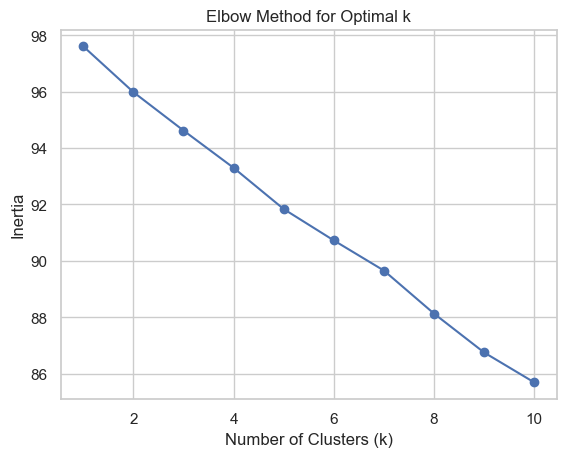

Number of articles in each cluster:
cluster
0     7
1     8
2    17
3    15
4    14
5     9
6    10
7    20
Name: count, dtype: int64


/Users/erinconeill/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/erinconeill/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/erinconeill/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


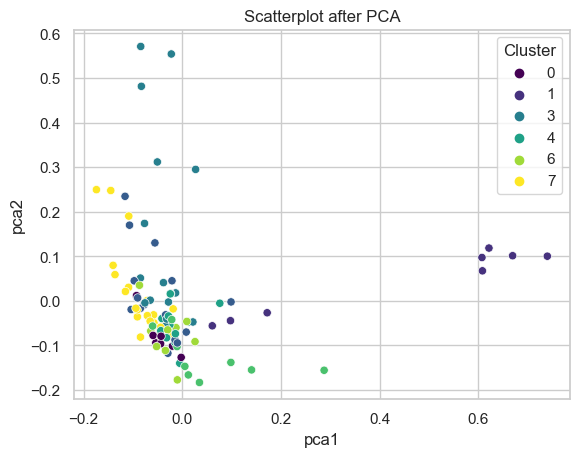

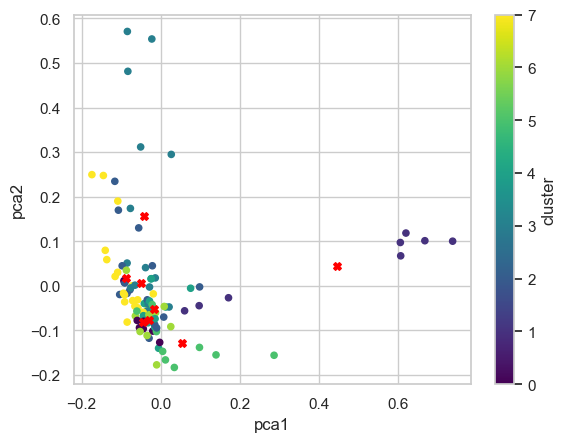

In [160]:
# WITH def functions

from newsapi import NewsApiClient
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import pandas as pd
import requests
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import scipy.spatial.distance as ssd

def tfidf(content):
    '''
    Function: tfidf
    Parameters: a list of strings, where each string represents a document
    Returns: a tuple containing a TFIDF maxtrix and a DataFrame of the matrix with columns representing feature names
    '''
    tfidf_vectorizer = TfidfVectorizer(stop_words = 'english')
    tfidf_matrix = tfidf_vectorizer.fit_transform(content)
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns = tfidf_vectorizer.get_feature_names_out())
    return tfidf_matrix, tfidf_df

def pca(tfidf_matrix, n_components):
    '''
    Function: pca
    Parameters: TFIDF matrix and number of components 
    Returns: DataFrame representing the matrix after PCA
    '''
    pca = PCA(n_components = n_components)
    pca_matrix = pca.fit_transform(tfidf_matrix.toarray())
    return pd.DataFrame(pca_matrix, columns = [f'pca{i}' for i in range(1, n_components + 1)])

def elbow_method(k_values, tfidf_matrix, title, x_label, y_label):
    '''
    Function: elbow_method
    Parameters: list of different values representing k and a TFIDF matrix
    '''
    results = []
    for k in k_values:
        kmeans = KMeans(n_clusters = k)
        kmeans.fit(tfidf_matrix)
        results.append(kmeans.inertia_)
    plt.plot(k_values, results, marker = 'o')
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.grid(True)
    plt.show()

def kmeans(tfidf_matrix, k_optimal, random_state_value):
    '''
    Function: kmeans
    Parameters: TFIDF matrix , number of clusters, random state value
    Returns: an array of assigned cluster labels 
    '''
    kmeans = KMeans(n_clusters = k_optimal, random_state = random_state_value)
    return kmeans.fit_predict(tfidf_matrix)

def plot_pca(df, column, palette):
    '''
    Function: plot_pca
    Parameters: DataFrame containing PCA components and cluster labels, column used for coloring clusters,
    and color palette for clusters 
    '''
    sns.scatterplot(x = 'pca1', y = 'pca2', hue = 'cluster', data = df, palette = palette)
    plt.title('Scatterplot after PCA')
    plt.legend(title = 'Cluster')
    plt.show()

# https://course.ccs.neu.edu/ds2500/lecnotes/lec17/kmeans_clustering_friday.html
def compute_centroids(df, k_optimal):
    '''
    Function: compute_centroids
    Parameters: DataFrame containing PCA components and cluster labels and the optimal number of clusters
    Returns: a list of tuples representing the centroid location for each cluster
    '''
    centroids = []
    for i in range(k_optimal):
        curr_cluster = df[df['cluster'] == i]
        avg_pca1 = curr_cluster['pca1'].mean()
        avg_pca2 = curr_cluster['pca2'].mean()
        centroids.append((avg_pca1, avg_pca2))
    return centroids

def plot_centroids(df, centroids):
    '''
    Function: plot_centroids 
    Parameters: DataFrame containing PCA components with cluster labels and a list of tuples for the centroids locations
    '''
    df.plot(kind = 'scatter', x = 'pca1', y = 'pca2', c = 'cluster', colormap = 'viridis')
    centroids_df = pd.DataFrame(centroids, columns = ['pca1', 'pca2'])
    centroids_df.plot(kind = 'scatter', x = 'pca1', y = 'pca2', marker = 'X', s = 30, c = 'red', ax=plt.gca())

def main():
    
    k_values = list(range(1, 11))
    n_components = 2
    random_state_value = 42
    k_optimal = 8

    # API
    APIKey = '0bb71990ea89451da9848d4c86f549d0'
    newsapi = NewsApiClient(api_key=APIKey)
    all_articles = newsapi.get_everything(q = 'AI',
                                          sources = 'bbc-news,the-verge',
                                          domains = 'bbc.co.uk,techcrunch.com',
                                          from_param = '2023-11-04',
                                          to = '2023-12-03',
                                          language = 'en',
                                          sort_by = 'relevancy',
                                          page = 2)

    # Create DataFrame for articles' data 
    articles = all_articles['articles']
    df = pd.DataFrame(articles)
    
    #TFIDF
    content = df['content']
    tfidf_matrix, tfidf_df = tfidf(content)
    
    # Q2 - PCA/what are the two values of the first article in your dataset?
    pca_df = pca(tfidf_matrix, n_components)
    df = pd.concat([df, pca_df], axis = 1)
    print(pca_df)
    
    # Q3/plot 2 - What value of k is optimal based on inertia?/Plot showing why you chose the value of k that you consider optimal 
    elbow_method(k_values, tfidf_matrix, 'Elbow Method for Optimal k', 'Number of Clusters (k)','Inertia')
    
    # KMeans clustering on the TFIDF matrix
    cluster_assignments = kmeans(tfidf_matrix, k_optimal, random_state_value)
    df['cluster'] = cluster_assignments

    # Q4 - Determine the number of articles in each optimized cluster 
    cluster_counts = df['cluster'].value_counts().sort_index()
    print("Number of articles in each cluster:")
    print(cluster_counts)

    # Plot 1.a - Scatterplot after PCA has been applied using Seaborn
    plot_pca(df, column='cluster', palette='viridis')
    
    # Plot 1.b - Scatterplot after PCA has been applied using Pandas
    centroids = compute_centroids(df, k_optimal)
    plot_centroids(df, centroids)

if __name__ == "__main__":
    main()


/Users/erinconeill/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


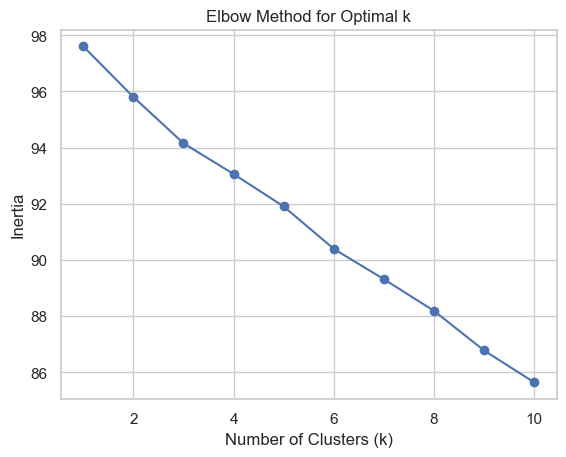

Number of articles in each cluster:
cluster
0     7
1     8
2    17
3    15
4    14
5     9
6    10
7    20
Name: count, dtype: int64


/Users/erinconeill/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/erinconeill/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/erinconeill/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


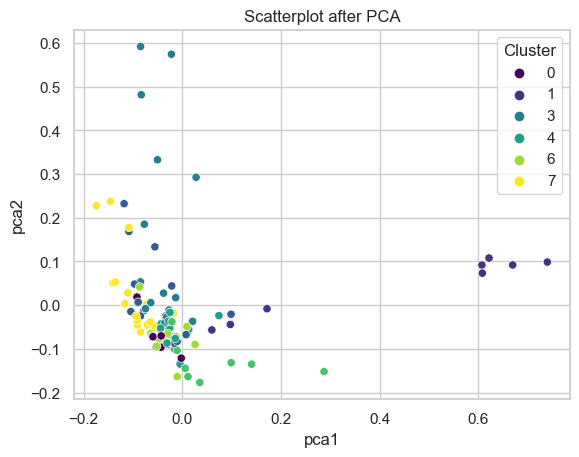

In [161]:
# WITHOUT def functions

# API 
APIKey = '0bb71990ea89451da9848d4c86f549d0'
newsapi = NewsApiClient(api_key=APIKey)
all_articles = newsapi.get_everything(q = 'AI',
                                      sources = 'bbc-news,the-verge',
                                      domains = 'bbc.co.uk,techcrunch.com',
                                      from_param = '2023-11-04',
                                      to = '2023-12-03',
                                      language = 'en',
                                      sort_by = 'relevancy',
                                      page = 2)

# Create DataFrame for articles' data
articles = all_articles['articles']
df = pd.DataFrame(articles)

# Content - 1743 stored elements
content = df['content']
tfidf_vectorizer = TfidfVectorizer(stop_words = 'english')
tfidf_matrix = tfidf_vectorizer.fit_transform(content)

# Probability 
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns = tfidf_vectorizer.get_feature_names_out())

# Q2
pca = PCA(n_components=2)
pca_matrix = pca.fit_transform(tfidf_matrix.toarray())
df[['pca1', 'pca2']] = pca_matrix

# Q3/plot 2 
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
k_values = list(range(1, 11))
results = []
for k in k_values:
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(tfidf_matrix)
    results.append(kmeans.inertia_)
plt.plot(k_values, results, marker = 'o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

# Q4
kmeans = KMeans(n_clusters = 8, random_state = 42)
df['cluster'] = kmeans.fit_predict(tfidf_matrix)
cluster_counts = df['cluster'].value_counts()
print('Number of articles in each cluster:')
print(cluster_counts.sort_index())

# Plot 1 - Scatterplot after PCA has been applied using Seaborn
# https://pandas.pydata.org/pandas-docs/version/0.25.3/reference/api/pandas.DataFrame.plot.scatter.html
sns.scatterplot(x = 'pca1', y = 'pca2', hue = 'cluster', data = df, palette = 'viridis')
plt.title('Scatterplot after PCA')
plt.xlabel('pca1')
plt.ylabel('pca2')
plt.legend(title = 'Cluster')
plt.show()